In [5]:
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import re, random, pickle, glob, os, difflib
import tensorflow as tf
import numpy as np
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
from utils import *

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3" 

In [6]:
print(tf.__version__)

2.3.1


In [7]:
train_root = 'train/'
test_root = 'test/'
model_root = 'models/'
plot_root = 'plots/'
train_set = ['x10_reads.fa']
test_sets = ['test_easy_1.fa', 'test_easy_2.fa', 'test_intermidate_1.fa', 'test_intermidate_2.fa', 'test_difficult_1.fa', 
             'test_difficult_2.fa', 'test_very_difficult_1.fa', 'test_very_difficult_2.fa']

In [10]:
df = read_fasta(test_root + test_sets[0])
train_reads_original = np.array(seqs2onehot(np.array(df.seqs)))

In [11]:
train_reads = np.delete(train_reads_original,3,axis=2)

In [12]:
train_reads = np.expand_dims(train_reads, -1)
train_reads.shape

(105492, 150, 4, 1)

In [13]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        output = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return output

In [14]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 150 * 4
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = -1*tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    def call(self, x):
        x = self.encoder(x)
        return self.decoder(x)

In [15]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [18]:
latent_dim = 32
width = 128
input_size = (150,4,1)
filter_size = (5, 4) 
epochs = 75
batch_size = 1024

In [17]:
ckpt_num = 'vanilla_vae'
ckpt_dir = os.path.join(model_root, ckpt_num, '')
if (os.path.isdir(ckpt_dir) == False):
    os.mkdir(os.path.join(ckpt_dir, ''))

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 9728)              87552     
_________________________________________________________________
reshape_1 (Reshape)          (None, 19, 4, 128)        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 38, 4, 128)        655488    
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 76, 4, 128)        655488    
_________________________________________________________________
batch_normalization_3 (Batch (None, 76, 4, 128)        512       
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 75, 4, 128)        0   

104/104 [==============================] - 9s 84ms/step - loss: 334.2892 - reconstruction_loss: 334.2892 - kl_loss: 1.4063e-05
Epoch 48/75
104/104 [==============================] - 9s 84ms/step - loss: 334.4511 - reconstruction_loss: 334.4510 - kl_loss: 1.4484e-05
Epoch 49/75
104/104 [==============================] - 9s 84ms/step - loss: 334.2769 - reconstruction_loss: 334.2768 - kl_loss: 1.2306e-05
Epoch 50/75
104/104 [==============================] - 9s 84ms/step - loss: 334.4080 - reconstruction_loss: 334.4080 - kl_loss: 2.0230e-05
Epoch 51/75
104/104 [==============================] - 9s 84ms/step - loss: 334.2541 - reconstruction_loss: 334.2541 - kl_loss: 2.6501e-05
Epoch 52/75
104/104 [==============================] - 9s 84ms/step - loss: 334.4374 - reconstruction_loss: 334.4374 - kl_loss: 1.6891e-05
Epoch 53/75
104/104 [==============================] - 9s 84ms/step - loss: 334.2579 - reconstruction_loss: 334.2578 - kl_loss: 2.5157e-05
Epoch 54/75
104/104 [==================

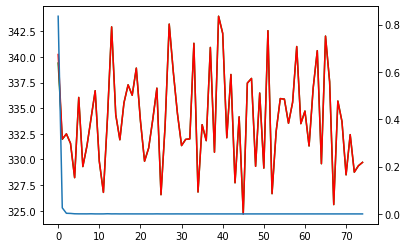

In [20]:
with strategy.scope():
    for f_size in [10]:
        for latent_dim in [8]:
            filter_size = (f_size, 4)
            model_path = os.path.join(model_root, ckpt_num, str(f_size)+'_'+str(latent_dim)+'.h5')
            hist_path = os.path.join(model_root, ckpt_num, str(f_size)+'_'+str(latent_dim))
            encoder_inputs = keras.Input(shape=input_size)
            x = layers.Conv2D(width, filter_size, activation="sigmoid", strides=(2,1), padding="same")(encoder_inputs)
            x = layers.Conv2D(width, filter_size, activation="sigmoid", strides=(2,1), padding="same")(x)
            x = layers.BatchNormalization()(x)
            x = layers.Conv2D(width, filter_size, activation="sigmoid", strides=(2,1), padding="same")(x)
            x = layers.Flatten()(x)
            x = layers.Dense(width, activation="relu")(x)
            z_mean = layers.Dense(latent_dim, name="z_mean")(x)
            z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
            z = Sampling()([z_mean, z_log_var])
            encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

            latent_inputs = keras.Input(shape=(latent_dim,))
            x = layers.Dense(19 * 4 * width, activation="relu")(latent_inputs)
            x = layers.Reshape((19, 4, width))(x)
            x = layers.Conv2DTranspose(width, filter_size, strides=(2, 1), padding="same")(x)
            x = layers.Conv2DTranspose(width, filter_size, strides=(2, 1), padding="same")(x)
            x = layers.BatchNormalization()(x)
            x = layers.Cropping2D(cropping=((0, 1), (0, 0)))(x)
            x = layers.Conv2DTranspose(width, filter_size, strides=(2, 1), padding="same")(x)
            decoder_outputs = layers.Conv2D(1, filter_size, activation="sigmoid", padding="same")(x)
            decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
            print(decoder.summary())
            vae = VAE(encoder, decoder)
            vae.compile(optimizer=keras.optimizers.Adam(0.0007))
            history = vae.fit(train_reads, epochs=epochs, batch_size=batch_size, verbose =1)
            with open(hist_path, 'wb') as f:
                pickle.dump(history.history, f)
            encoder.save(model_path)
            
            fig, ax1 = plt.subplots()
            ax1.plot(history.history['reconstruction_loss'], color='green')
            ax1.plot(history.history['loss'], color='red')


            ax2 = ax1.twinx()
            ax2.plot(history.history['kl_loss'])
            plot_path = os.path.join(plot_root, str(f_size)+'_'+str(latent_dim)+'_loss''.png')
            plt.savefig(plot_path)